# Assignment: Feature Detection and Tracking on KITTI Dataset

This file is in extension with the already assignment given to you. This part focuses on detecting and tracking features using **SIFT**, **SURF**, or **ORB** on the provided KITTI dataset. You will implement **feature detection**, **matching**, and **visualizing the results** using OpenCV in Python. The dataset consists of 200 images.

## Objectives

1. Detect SIFT/SURF/ORB features and descriptors in the images.
2. Match features across the sequence of images using Brute-Force Matching.
3. Improve matching by using the 1NN/2NN ratio test and cross-validation check for removing ambiguous correspondences. Calculate the average number of tracked keypoints per frame after considering two matching outlier tests.
4. Create a video of the generated images for visualizing the tracking results with the outlier removal tests.
5. Compare the results obtained from corner tracking with SIFT descriptors, SIFT features and descriptors, ORB, and SURF.

## Submission guide

### Submission deadline: 31/08/2024 @ 23h59

Submit the following:
1. Python code as a Jupyter notebook file.
2. The generated video files.
3. A report inside the notebook summarizing the comparison results.
4. Create a folder with your name and roll number to upload the results.

## References

[Sift OpenCV](https://docs.opencv.org/4.x/da/df5/tutorial_py_sift_intro.html)<br><br>
[Surf OpenCV](https://docs.opencv.org/3.4/df/dd2/tutorial_py_surf_intro.html)<br><br>
[ORB OpenCV](https://docs.opencv.org/3.4/d1/d89/tutorial_py_orb.html)<br><br>
[Visual Feature Part 1: Computing Keypoints (Cyrill Stachniss)](https://www.youtube.com/watch?v=nGya59Je4Bs)<br><br>
[Visual Features Part 2: Features Descriptors (Cyrill Stachniss)](https://www.youtube.com/watch?v=CMolhcwtGAU)<br><br>
[Scale-invariant Feature Transform (SIFT) Dr Muabark Shah](https://www.youtube.com/watch?v=NPcMS49V5hg)<br><br>



---

Make sure to replace placeholder paths with actual paths to the images in your dataset and to thoroughly document your code and findings. Good luck!


In [18]:
import cv2 as cv
import os 
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import convolve
from matplotlib.patches import FancyArrowPatch


## Instructions

1. **Detect SIFT/SURF/ORB Features and Descriptors**

   Use the following sample code to detect features and descriptors in the images. Replace the image paths and adapt the code for SIFT, SURF, and ORB.

In [19]:
def convert_to_grayscale(image_path):
    """Convert an image to grayscale."""
    img = cv.imread(image_path)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    return img, gray

def detect_and_draw_sift(gray, img):
    """Detect SIFT keypoints and descriptors, and draw them on the image."""
    sift = cv.SIFT_create()
    kp, des = sift.detectAndCompute(gray, None)
    img_sift = cv.drawKeypoints(gray, kp, img, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    cv.imwrite('sift_keypoints.jpg', img_sift)
    return kp, des

def detect_and_draw_surf(gray, img):
    """Detect SURF keypoints and descriptors, and draw them on the image."""
    surf = cv.SURF_create(400)
    kp, des = surf.detectAndCompute(gray, None)
    img_surf = cv.drawKeypoints(gray, kp, img, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    cv.imwrite('surf_keypoints.jpg', img_surf)
    return kp, des

def detect_and_draw_orb(gray, img):
    """Detect ORB keypoints and descriptors, and draw them on the image."""
    orb = cv.ORB_create()
    kp = orb.detect(img, None)
    kp, des = orb.compute(img, kp)
    img_orb = cv.drawKeypoints(gray, kp, img, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    cv.imwrite('orb_keypoints.jpg', img_orb)
    return kp, des

2. **Match Features Across Images Using Brute-Force Matching**

   Implement feature matching using the Brute-Force matcher.

In [20]:
def match_features(des1, des2):
    """Match features using Brute-Force Matcher and save the matches."""
    bf = cv.BFMatcher(cv.NORM_L2, crossCheck=True)
    matches = bf.match(des1, des2)
    matches = sorted(matches, key=lambda x: x.distance)
    return matches

# Save Matches 

In [21]:
def draw_and_save_matches(img1, kp1, img2, kp2, matches, filename):
    """Draw matches between two images and save the output."""
    img_matches = cv.drawMatches(img1, kp1, img2, kp2, matches, None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    cv.imwrite(filename, img_matches)

3. **Improve Matching with Ratio Test and Cross-Validation Check**

   Implement the 1NN/2NN ratio test and cross-validation check.


In [22]:
def knn_match_and_ratio_test(des1, des2):
    """Perform K-Nearest Neighbor matching with a ratio test."""
    bf = cv.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2)
    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)
    return good_matches

In [23]:
def visualize_matches(first_image, keypoint_one, second_image, keypoint_two, matches):
    """
    Visualize corresponding matches between two images by connecting match points with lines only.
    """
    # Draw only the matches with lines connecting them, no keypoints
    show_matches = cv.drawMatches(
        first_image, keypoint_one, second_image, keypoint_two, matches, None,
        flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    
    # Display the image with matches
    plt.figure(figsize=(15, 5), dpi=100)
    plt.imshow(show_matches)
    plt.axis('off')  # Turn off the axis
    plt.show()

# Visual Matching

In [24]:
def matches_vis(image_tgt, list_keypoints_src, list_keypoints_tgt, matches, output_path, dpi=100):
    # Convert grayscale image to RGB
    if len(image_tgt.shape) == 2:  # If the image is grayscale
        image_color = cv.merge([image_tgt, image_tgt, image_tgt]).astype(np.uint8)
    else:
        image_color = image_tgt.copy()

    # Draw cross markers for target keypoints in red
    for keyp in list_keypoints_tgt:
        x, y = keyp.pt
        cv.drawMarker(image_color, (int(x), int(y)), (0, 0, 255), markerType=cv.MARKER_CROSS, markerSize=10, thickness=2, line_type=cv.LINE_8)

    # Draw lines between matched keypoints in green
    for match in matches:
        # Extract the indices from cv2.DMatch object
        i = match.queryIdx
        j = match.trainIdx
        
        coord_src = list_keypoints_src[i].pt
        coord_tgt = list_keypoints_tgt[j].pt
        
        cv.line(image_color, (int(coord_tgt[0]), int(coord_tgt[1])), (int(coord_src[0]), int(coord_src[1])), (0, 255, 0), 1)
    
    # Get image dimensions
    height, width = image_tgt.shape[:2]

    # Display image with the same size as the original image
    plt.figure(figsize=(width / dpi, height / dpi), dpi=dpi)  # Set figure size
    plt.imshow(cv.cvtColor(image_color, cv.COLOR_BGR2RGB))  # Convert to RGB for displaying
    plt.axis('off')
    plt.savefig(output_path, bbox_inches='tight', pad_inches=0, dpi=1.5*dpi)
    plt.close()

    return image_color

# RANSAC

In [25]:
def find_homography_ransac(matches, keypoints1, keypoints2, n_iterations=10000, threshold=10.0):
    best_homography = None
    best_inliers = []

    for _ in range(n_iterations):
        # Step 1: Randomly select 4 matches
        sample_indices = np.random.choice(len(matches), 4, replace=False)
        sample_matches = [matches[i] for i in sample_indices]
        
        # Get the corresponding points from both images using cv.DMatch attributes
        pts1 = np.float32([keypoints1[m.queryIdx].pt for m in sample_matches])
        pts2 = np.float32([keypoints2[m.trainIdx].pt for m in sample_matches])
        
        # Step 2: Estimate homography
        H, _ = cv.findHomography(pts1, pts2, method=0)  # Method=0 uses the Direct Linear Transformation (DLT)

        if H is None:
            continue

        # Step 3: Compute inliers
        inliers = []
        for i, match in enumerate(matches):
            pt1 = np.append(keypoints1[match.queryIdx].pt, 1)  # Convert to homogeneous coordinates
            pt2 = keypoints2[match.trainIdx].pt
            
            projected_pt1 = np.dot(H, pt1)

            # Check for divide by zero
            if projected_pt1[2] == 0:
                continue  # Skip this point

            projected_pt1 /= projected_pt1[2]  # Convert back to Cartesian coordinates
            
            error = np.linalg.norm(pt2 - projected_pt1[:2])
            if error < threshold:
                inliers.append(match)

        # Step 4: Update the best model
        if len(inliers) > len(best_inliers):
            best_homography = H
            best_inliers = inliers
    
    return best_homography, best_inliers

4. **Calculate the average number of tracked keypoints per frame.**

In [26]:
def calculate_average_keypoints_per_frame(good_matches, num_images):
    """Calculate the average number of tracked keypoints per frame."""
    avg_keypoints = len(good_matches) / num_images
    print(f'Average number of tracked keypoints per frame: {avg_keypoints}')
    return avg_keypoints

5. **Create a Video for Visualizing the Tracking Results**

   Use the following function to create a video from the tracked images.


In [27]:
def make_video(list_image_names):
    """Create a video from a list of images."""
    img_array = []
    for filename in sorted(list_image_names):
        img = cv.imread(filename)
        img_array.append(img)

    height, width, layers = img.shape
    size = (width, height)

    video_wr = cv.VideoWriter('corner_tracking_patch.mp4', cv.VideoWriter_fourcc(*'mp4v'), 3, size)

    for img in img_array:
        video_wr.write(img)
    video_wr.release()


6. **Compare the Results**

   Compare the results obtained from different methods:
   - Corner tracking with SIFT descriptors
   - SIFT features and descriptors
   - ORB
   - SURF

   Summarize your findings in a report\markdown cell, including the average number of tracked keypoints and any observations regarding the performance and accuracy of each method.

Average number of tracked keypoints per frame: 673.0


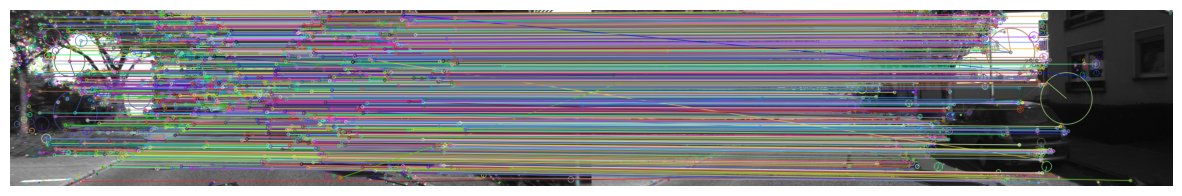

raw
Average number of tracked keypoints per frame: 93.5
refined
Average number of tracked keypoints per frame: 8.5


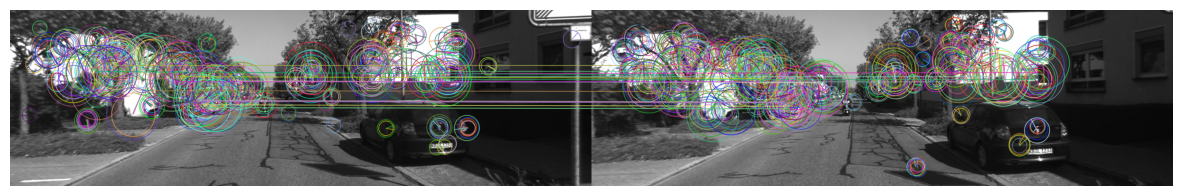

In [28]:
image_path1 = 'U:\\Final Year Project\\FYP-2\\Tasks\\Feature Extraction\\CV_Assignment_1_CornerTracker\\images\\000000.png'

image_path2 = 'U:\\Final Year Project\\FYP-2\\Tasks\\Feature Extraction\\CV_Assignment_1_CornerTracker\\images\\000001.png'    
image_paths = [image_path1, image_path2]  # Add your actual image paths here

    # Convert to grayscale and detect keypoints
img1, gray1 = convert_to_grayscale(image_paths[0])
    
img2, gray2 = convert_to_grayscale(image_paths[1])

    # Detect keypoints and descriptors
kp_sift1, des_sift1 = detect_and_draw_sift(gray1, img1)
kp_sift2, des_sift2 = detect_and_draw_sift(gray2, img2)

    # Match features
matches = match_features(des_sift1, des_sift2)
# draw_and_save_matches(img1, kp_sift1, img2, kp_sift2, matches[:50], 'matches.jpg')

    # Perform KNN match with ratio test
good_matches = knn_match_and_ratio_test(des_sift1, des_sift2)
# draw_and_save_matches(img1, kp_sift1, img2, kp_sift2, good_matches, 'good_matches.jpg')


    # Calculate average keypoints
calculate_average_keypoints_per_frame(good_matches, len(image_paths))

    # Plot feature matches
visualize_matches(img1, kp_sift1, img2, kp_sift2, good_matches)

kp_orb1, des_orb1 = detect_and_draw_orb(gray1, img1)
kp_orb2, des_orb2 = detect_and_draw_orb(gray2, img2)

    # Match features
matches = match_features(des_orb1, des_orb2)

    # Perform KNN match with ratio test
good_matches = knn_match_and_ratio_test(des_orb1, des_orb2)

    # Calculate average keypoints
print('raw')
calculate_average_keypoints_per_frame(matches, len(image_paths))
print('refined')
calculate_average_keypoints_per_frame(good_matches, len(image_paths))
  # Plot feature matches
visualize_matches(img1, kp_orb1, img2, kp_orb2, good_matches)

   

In [29]:
def process_images(input_folder, output_folder):
    # Create the main output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    
    matches_folder = os.path.join(output_folder, 'sift_matches')

    # Create subfolders if they don't exist
    for folder in [matches_folder]:
        if not os.path.exists(folder):
            os.makedirs(folder)

    # List all image files in the input folder
    image_files = sorted([f for f in os.listdir(input_folder) if f.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff'))])

    # Loop through all the images
    for i in range(len(image_files) - 1):
        image1_path = os.path.join(input_folder, image_files[i])
        image2_path = os.path.join(input_folder, image_files[i+1])
        image_paths = [image1_path, image2_path] 

        img1, gray1 = convert_to_grayscale(image_paths[0])
    
        img2, gray2 = convert_to_grayscale(image_paths[1])

    # Detect keypoints and descriptors
        kp_sift1, des_sift1 = detect_and_draw_sift(gray1, img1)
        kp_sift2, des_sift2 = detect_and_draw_sift(gray2, img2)

    # Match features
        matches = match_features(des_sift1, des_sift2)
     # draw_and_save_matches(img1, kp_sift1, img2, kp_sift2, matches[:50], 'matches.jpg')

    # Perform KNN match with ratio test
        good_matches = knn_match_and_ratio_test(des_sift1, des_sift2)

        # Generate base filenames with zero-padded numbers
        base_filename1 = os.path.splitext(image_files[i])[0].zfill(6)
        base_filename2 = os.path.splitext(image_files[i+1])[0].zfill(6)


        # Save matches
        output = os.path.join(matches_folder, f'{base_filename1}matching_sift.jpg')

        matches_vis(img2,kp_sift1,kp_sift2,good_matches,output)


In [30]:
def process_images1(input_folder, output_folder):
    # Create the main output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    
    matches_folder = os.path.join(output_folder, 'orb_matches')

    # Create subfolders if they don't exist
    for folder in [matches_folder]:
        if not os.path.exists(folder):
            os.makedirs(folder)

    # List all image files in the input folder
    image_files = sorted([f for f in os.listdir(input_folder) if f.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff'))])

    # Loop through all the images
    for i in range(len(image_files) - 1):
        image1_path = os.path.join(input_folder, image_files[i])
        image2_path = os.path.join(input_folder, image_files[i+1])
        image_paths = [image1_path, image2_path] 

        img1, gray1 = convert_to_grayscale(image_paths[0])
    
        img2, gray2 = convert_to_grayscale(image_paths[1])

        kp_orb1, des_orb1 = detect_and_draw_orb(gray1, img1)
        kp_orb2, des_orb2 = detect_and_draw_orb(gray2, img2)

    # Match features
        matches = match_features(des_orb1, des_orb2)

    # Perform KNN match with ratio test
        good_matches = knn_match_and_ratio_test(des_orb1, des_orb2)

        # Generate base filenames with zero-padded numbers
        base_filename1 = os.path.splitext(image_files[i])[0].zfill(6)
        base_filename2 = os.path.splitext(image_files[i+1])[0].zfill(6)


        # Save matches
        output = os.path.join(matches_folder, f'{base_filename1}matching_orb.jpg')

        matches_vis(img2,kp_sift1,kp_sift2,good_matches,output)


In [31]:
def create_video_from_images(image_folder, output_video_path, fps=10):
    # Get a list of all image files in the folder (sorted by filename)
    image_files = [f for f in sorted(os.listdir(image_folder)) if f.endswith(('png', 'jpg', 'jpeg', 'bmp'))]
    
    # Read the first image to get the dimensions
    first_image_path = os.path.join(image_folder, image_files[0])
    first_image = cv.imread(first_image_path)
    height, width, layers = first_image.shape
    
    # Initialize the VideoWriter
    video_writer = cv.VideoWriter(output_video_path, cv.VideoWriter_fourcc(*'mp4v'), fps, (width, height))
    
    # Add each image as a frame to the video
    for image_file in image_files:
        image_path = os.path.join(image_folder, image_file)
        image = cv.imread(image_path)
        video_writer.write(image)
    
    # Release the VideoWriter
    video_writer.release()
    print(f"Video saved at {output_video_path}")

In [32]:
input_folder = 'U:\\Final Year Project\\FYP-2\\Tasks\\Feature Extraction\\CV_Assignment_1_CornerTracker\\images'

output_folder = 'U:\\Final Year Project\\FYP-2\\Tasks\\Feature Extraction\\CV_Assignment_1_CornerTracker'

output_video_file = 'U:\\Final Year Project\\FYP-2\\Tasks\\Feature Extraction\\CV_Assignment_1_CornerTracker\\sift_matches'

output_video_file1 = 'U:\\Final Year Project\\FYP-2\\Tasks\\Feature Extraction\\CV_Assignment_1_CornerTracker\\orb_matches'

In [33]:
process_images(input_folder, output_folder)

In [34]:
input_path = os.path.join(output_folder, 'sift_matches')

output_video_path = os.path.join(output_video_file, 'sift_matches.mp4')

create_video_from_images(input_path, output_video_path)

In [35]:
process_images1(input_folder, output_folder)

In [36]:
input_path = os.path.join(output_folder, 'orb_matches')

output_video_path = os.path.join(output_video_file1, 'orb_matches.mp4')

create_video_from_images(input_path, output_video_path)

Video saved at U:\Final Year Project\FYP-2\Tasks\Feature Extraction\CV_Assignment_1_CornerTracker\orb_matches\orb_matches.mp4
